In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools


from keras.utils.np_utils import to_categorical #one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white',context='notebook',palette='deep')


Using TensorFlow backend.


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

In [3]:
#setting up the target
y_train=train['label']
#setting data
X_train = train.drop(labels = ["label"],axis = 1) 

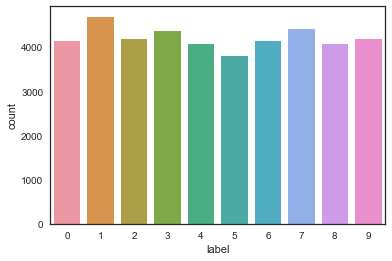

In [4]:
sns.countplot(y_train)



In [5]:
(y_train.value_counts().sort_values())

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64

In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
#grayscale normalizing
X_train=X_train/255.0
test=test/255.0

In [9]:
#train and test vectors are stacked up as 1d vectors with 784 values. Here we convert it to a 3D matrix.
#Because MNIST is grayscale we use 1 channel, otherwise we'd have 3 channels
#-1 because we keep initial dimension of 42k, which is the number of examples
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [10]:
#kers.utisl.np_utils has to_categorical which is basically one hot encoding
#we will use that here
y_train=to_categorical(y_train,num_classes=10)


In [11]:
random_seed=3

In [12]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=random_seed)

In [13]:
X_train.shape

(37800, 28, 28, 1)

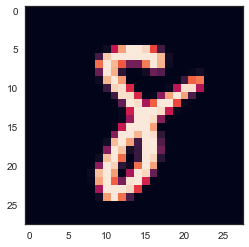

In [14]:
#plotting a random image
plt.imshow(X_train[10][:,:,0])

In [30]:
#building the model
#we introduce two conv2d layers, maxpool2d layers and then two dense layers
#Conv2D layers have learnable filters about the data

model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64,kernel_size=(3,3),padding="Same",activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))




In [16]:
#here rho is beta2
optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [17]:
#categorical crossentropy is a good loss function for when there is 2 or more categories of outputs
#optimizer defined in previous cell
#the metric function accuracy is similar to the loss function except that it is not used during training only while testing
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


In [18]:
#a good way to set the learning rate alpha is by using ReduceLROnPlateau. Here, we halve the alpha if accuracy is not
#improved whithin 3 epochs. So this way we can use the panda approach to tuning the hyperparamaters

learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc', #quantity to be monitored
                                          patience=3, #no of epochs to wait for before reducing alpha
                                          verbose=1, #TRUE
                                          factor=0.5, #factor by which learning rate will be reduced
                                          min_lr=0.00001 #minimum learning rate beyond which no reduction
                                         )

In [19]:
epochs=30
batch_size=128

In [20]:
#We now must perform data augmentation to avoid overfitting. 
#One of the ways to combat overfitting is by getting more data, which augmentation does
#Randomly rotate some training images by 10 degrees
#Randomly Zoom by 10% some training images
#Randomly shift images horizontally by 10% of the width
#Randomly shift images vertically by 10% of the height

new_data=ImageDataGenerator(featurewise_center=False,
                           samplewise_center=False,
                           featurewise_std_normalization=False,
                           samplewise_std_normalization=False,
                           zca_whitening=False,
                           rotation_range=10, #in degrees
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=False,
                           vertical_flip=False
                           )

In [21]:
new_data.fit(X_train)

In [22]:
#Now we train the model
history = model.fit_generator(new_data.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_val,y_val),
                              verbose = 2,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])


Epoch 1/30
 - 20s - loss: 0.4817 - acc: 0.8441 - val_loss: 0.0766 - val_acc: 0.9745
Epoch 2/30
 - 7s - loss: 0.1445 - acc: 0.9569 - val_loss: 0.0501 - val_acc: 0.9824
Epoch 3/30
 - 7s - loss: 0.1036 - acc: 0.9693 - val_loss: 0.0403 - val_acc: 0.9886
Epoch 4/30
 - 7s - loss: 0.0845 - acc: 0.9750 - val_loss: 0.0320 - val_acc: 0.9898
Epoch 5/30
 - 8s - loss: 0.0709 - acc: 0.9788 - val_loss: 0.0318 - val_acc: 0.9898
Epoch 6/30
 - 7s - loss: 0.0657 - acc: 0.9808 - val_loss: 0.0299 - val_acc: 0.9912
Epoch 7/30
 - 8s - loss: 0.0624 - acc: 0.9808 - val_loss: 0.0251 - val_acc: 0.9921
Epoch 8/30
 - 8s - loss: 0.0561 - acc: 0.9830 - val_loss: 0.0280 - val_acc: 0.9914
Epoch 9/30
 - 8s - loss: 0.0554 - acc: 0.9843 - val_loss: 0.0365 - val_acc: 0.9907
Epoch 10/30
 - 8s - loss: 0.0523 - acc: 0.9846 - val_loss: 0.0296 - val_acc: 0.9905

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 8s - loss: 0.0417 - acc: 0.9878 - val_loss: 0.0230 - val_acc: 0.9929
Epo

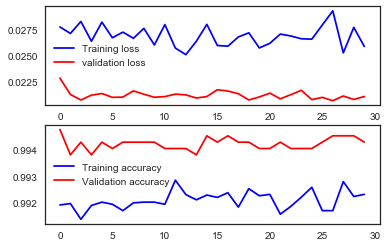

In [43]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
results

0        2
1        0
2        9
3        0
4        3
5        7
6        0
7        3
8        0
9        3
10       5
11       7
12       4
13       0
14       4
15       3
16       3
17       1
18       9
19       0
20       9
21       1
22       1
23       5
24       7
25       4
26       2
27       7
28       4
29       7
        ..
27970    5
27971    0
27972    4
27973    8
27974    0
27975    3
27976    6
27977    0
27978    1
27979    9
27980    3
27981    1
27982    1
27983    0
27984    4
27985    5
27986    2
27987    2
27988    9
27989    6
27990    7
27991    6
27992    1
27993    9
27994    7
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [25]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [29]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [28]:
sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
